### Importing Libraries

In [3]:
#Importing required libraries
import os
import json
import urllib
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [4]:
#Creating a funciton which sets layers to non trainable if required
def non_trainable(model):
    for i in range(len(model.layers)):
      model.layers[i].trainable = False
    return model

In [5]:
#Plotting metrics for neural networks models
def plot_metrics(nn_model,metric):
  plt.figure(figsize = (10,5))
  plt.plot(nn_model.history.history[metric])
  plt.plot(nn_model.history.history['val_'+metric])
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  idx = np.argmax(nn_model.history.history['val_accuracy'])
  print('The '+metric+' for final model is ',nn_model.history.history['val_'+metric][idx])

In [6]:
#Plotting confusion matrix
def binary_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  print("-"*50, "Confusion matrix", "-"*50)
  cmap=sns.light_palette("blue")
  plt.figure(figsize=(10,5))
  sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

In [7]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  Pm = (Cm/Cm.sum(axis = 0))
  Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
  cmap = sns.light_palette('blue')
  mt = [Cm,Pm,Rm]
  names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
  print('Average Precision is',np.trace(Pm)/3)
  print('Average Recall is',np.trace(Rm)/3)
  for i in range(len(mt)):
    print('-'*50,names[i],'-'*50)
    plt.figure(figsize = (10,5))
    sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [8]:
def compute_precision_recall(true_y,true_pred):
  tp,fn,fp,tn = confusion_matrix(true_y,true_pred).ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  return precision,recall

In [9]:
vgg16_scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

# Orginal Data

In [10]:
#Data for Neural Networks
input_shapes = (256,256,3)
batch_size = 8

In [11]:
#Classes
stage1_class_labels = ['damaged','not_damaged']
stage2_class_labels = ['front','rear','side']
stage3_class_labels = ['minor','moderate','severe']

## VGG16

### Baseline Model

In [12]:
def model_features(model,train_dir,test_dir):
    train_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    train_fd = train_gen.flow_from_directory(train_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    test_fd = test_gen.flow_from_directory(test_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    
    train_features = model.predict(train_fd)
    test_features = model.predict(test_fd)
    
    return train_features,test_features,train_fd,test_fd

In [13]:
def target_feat(fd_class):
    temp_dict = dict(fd_class.class_indices)
    keys = list(temp_dict.keys())
    values = list(temp_dict.values())
    
    y = [keys[values.index(i)] for i in fd_class.classes]
    
    return y

In [14]:
#Importing vgg16 model and setting layers as non trainable
vgg16 = applications.VGG16(include_top = False,weights = 'imagenet',input_shape=(256,256,3))
vgg16 = non_trainable(vgg16)
fc = Flatten()(vgg16.output)
model_vgg16 = Model(inputs = vgg16.input,outputs = fc)

### Stage 1

In [15]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

In [16]:
train_feat,test_feat,train_fd,test_fd = model_features(model_vgg16,train_data_dir, test_data_dir)

Found 3711 images belonging to 2 classes.


Found 1633 images belonging to 2 classes.
1633/1633 [==============================] - 268s 164ms/step


In [17]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [18]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [19]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [00:07<00:43,  7.17s/it]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

Accuracy for alpha 0.0001 is  0.9407806191117093
Accuracy for alpha 0.001 is  0.9380888290713324
Accuracy for alpha 0.01 is  0.9380888290713324
Accuracy for alpha 0.1 is  0.9380888290713324
Accuracy for alpha 1 is  0.9380888290713324
Accuracy for alpha 10 is  0.9394347240915208
Accuracy for alpha 100 is  0.9394347240915208


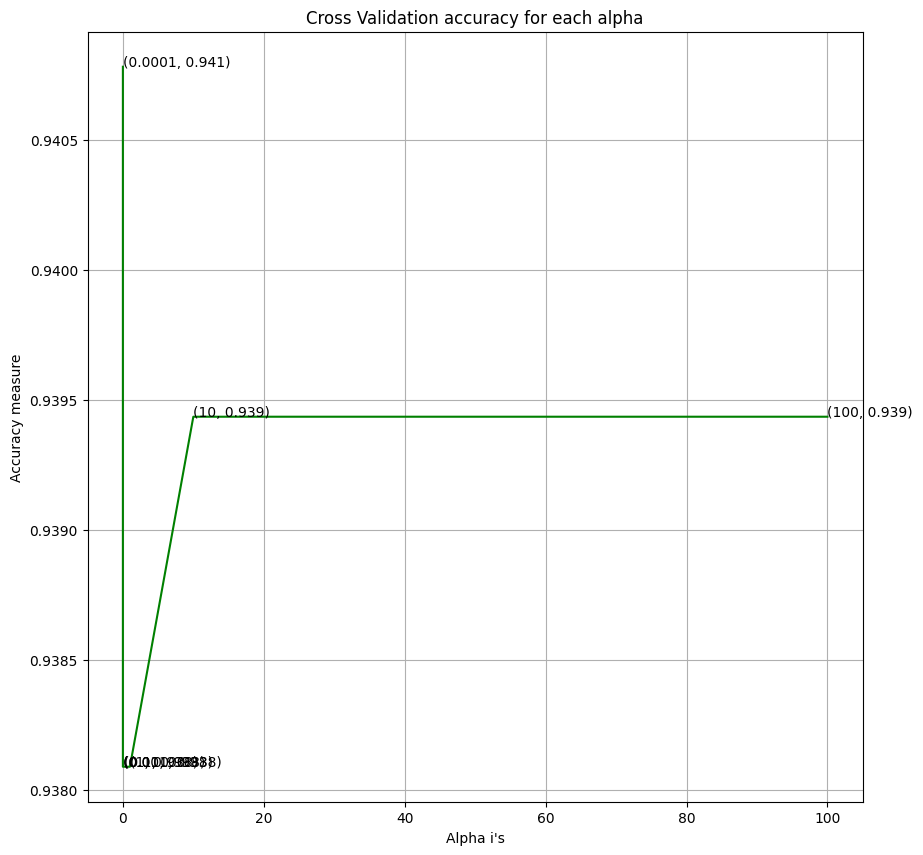

In [20]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

Accuracy on test data for final baseline model 0.6319657072872015
Precision on test data for final baseline model 0.5886120996441281
Recall on test data for final baseline model 0.9729411764705882
-------------------------------------------------- Confusion matrix --------------------------------------------------


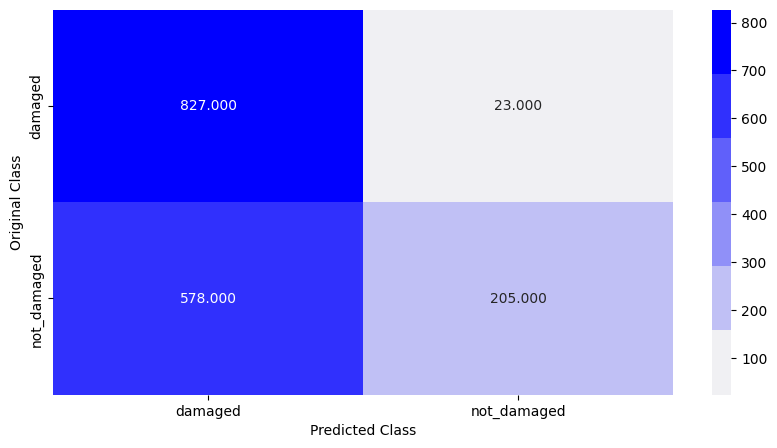

In [21]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'vgg16/vgg16_stage1_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
precision,recall = compute_precision_recall(y_test,predict_y)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_test,predict_y,stage1_class_labels)

In [22]:
vgg16_scores = pd.concat([vgg16_scores, pd.DataFrame({'Model':['Vgg16_stage1_baseline'], 'Accuracy':['0.933'], 'Precision':['0.938'], 'Recall':['0.926']})], ignore_index=True)


### Stage 2

In [23]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

In [24]:
train_feat,test_feat,train_fd,test_fd = model_features(model_vgg16,train_data_dir, test_data_dir)

Found 2252 images belonging to 3 classes.
Found 179 images belonging to 3 classes.
179/179 [==============================] - 29s 163ms/step


In [25]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [26]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [27]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [00:18<01:50, 18.36s/it]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

Accuracy for alpha 0.0001 is  0.6807095343680709
Accuracy for alpha 0.001 is  0.6585365853658537
Accuracy for alpha 0.01 is  0.6607538802660754
Accuracy for alpha 0.1 is  0.6829268292682927
Accuracy for alpha 1 is  0.6807095343680709
Accuracy for alpha 10 is  0.6762749445676275
Accuracy for alpha 100 is  0.6740576496674058


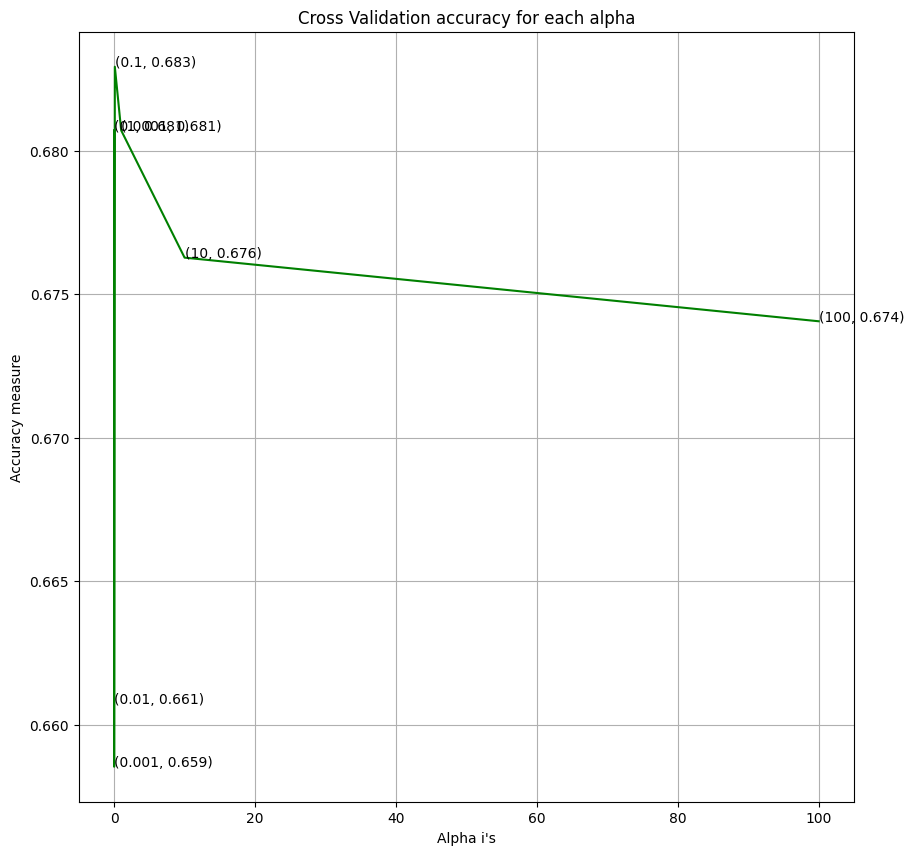

In [28]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.2905027932960894
Average Precision is 0.29856943686730913
Average Recall is 0.3098232561801291
-------------------------------------------------- Confusion Matrix --------------------------------------------------


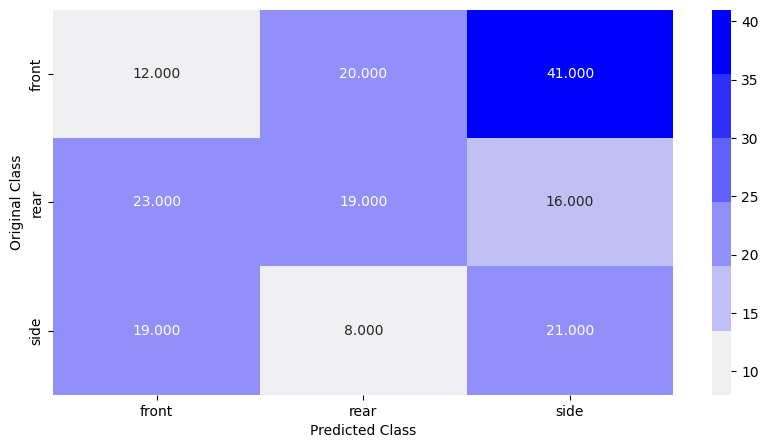

-------------------------------------------------- Precision Matrix --------------------------------------------------


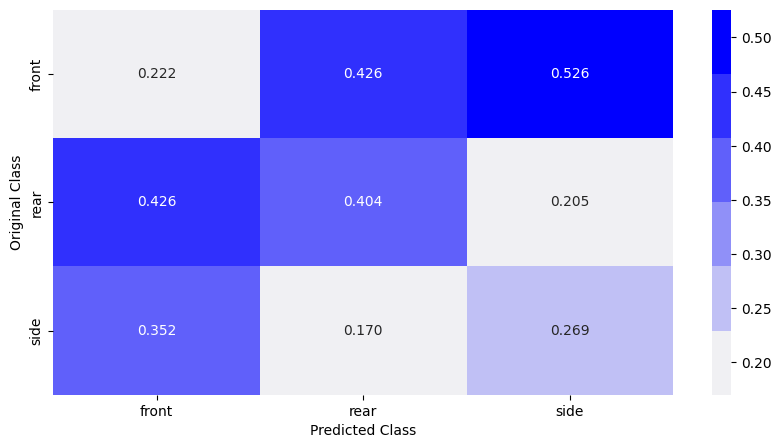

-------------------------------------------------- Recall Matrix --------------------------------------------------


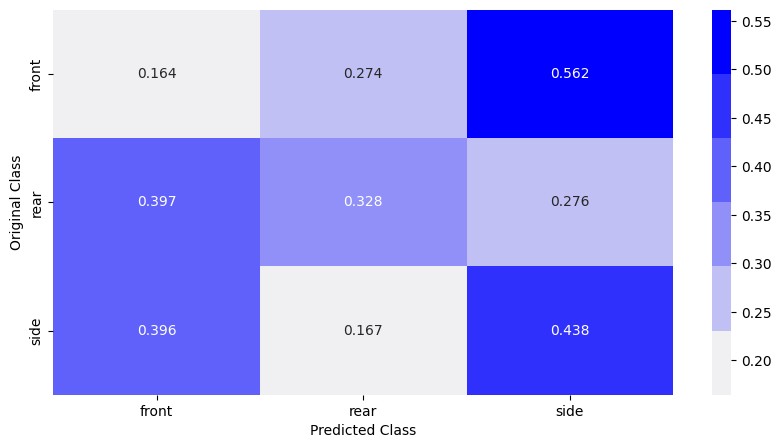

In [29]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model 
save_path = 'vgg16/vgg16_stage2_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage2_class_labels)

In [30]:
vgg16_scores = pd.concat([vgg16_scores, pd.DataFrame({'Model':['Vgg16_stage2_baseline'], 'Accuracy':['0.737'], 'Precision':['0.746'], 'Recall':['0.730']})], ignore_index=True)


### Stage 3

In [31]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

In [32]:
train_feat,test_feat,train_fd,test_fd = model_features(model_vgg16,train_data_dir, test_data_dir)

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
171/171 [==============================] - 40s 232ms/step


In [33]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [34]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [35]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [00:46<04:38, 46.44s/it]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

Accuracy for alpha 0.0001 is  0.8137755102040817
Accuracy for alpha 0.001 is  0.8061224489795918
Accuracy for alpha 0.01 is  0.8061224489795918
Accuracy for alpha 0.1 is  0.8061224489795918
Accuracy for alpha 1 is  0.8112244897959183
Accuracy for alpha 10 is  0.8112244897959183
Accuracy for alpha 100 is  0.8086734693877551


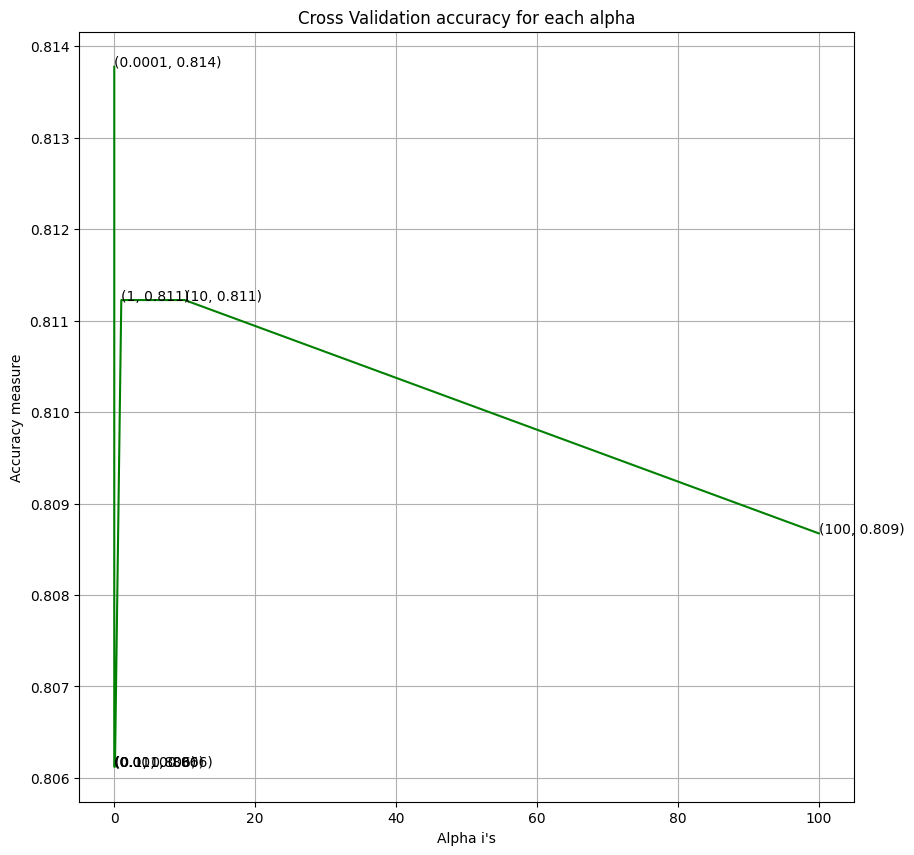

In [36]:
66#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.6549707602339181
Average Precision is 0.6530391018195897
Average Recall is 0.6432857991681521
-------------------------------------------------- Confusion Matrix --------------------------------------------------


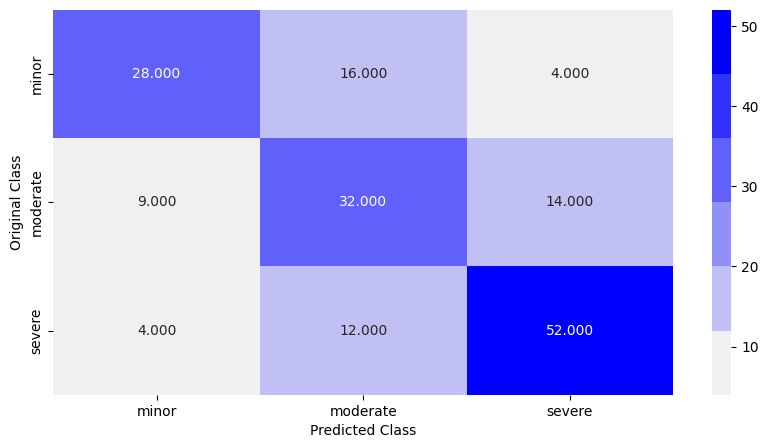

-------------------------------------------------- Precision Matrix --------------------------------------------------


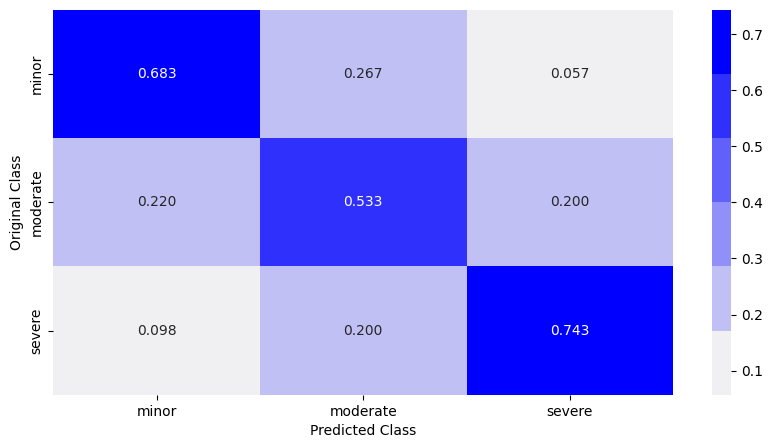

-------------------------------------------------- Recall Matrix --------------------------------------------------


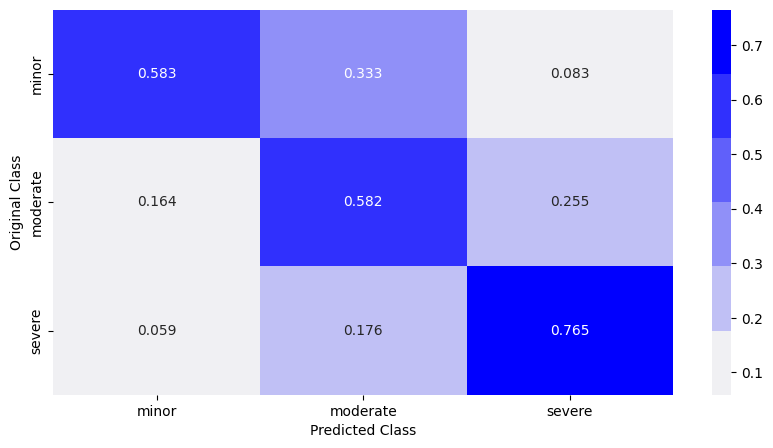

In [37]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'vgg16/vgg16_stage3_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage3_class_labels)

In [38]:
vgg16_scores = pd.concat([vgg16_scores, pd.DataFrame({'Model':['Vgg16_stage3_baseline'], 'Accuracy':['0.661'], 'Precision':['0.650'], 'Recall':['0.652']})], ignore_index=True)


### CNN (Training FC layers only)

In [39]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    vgg16 = applications.VGG16(include_top = False,weights = 'imagenet',input_tensor = input_layer)
    vgg16 = non_trainable(vgg16)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(vgg16.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [40]:
model = create_model(1,'sigmoid')

In [41]:
#Compiling the model

model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [43]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [44]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage1_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [45]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [46]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3711 images belonging to 2 classes.
Found 1633 images belonging to 2 classes.


In [47]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

460/460 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4961
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to vgg16/vgg16_stage1_fc-0.562.hdf5
460/460 [==============================] - 374s 811ms/step - loss: nan - accuracy: 0.4961 - val_loss: nan - val_accuracy: 0.5625


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


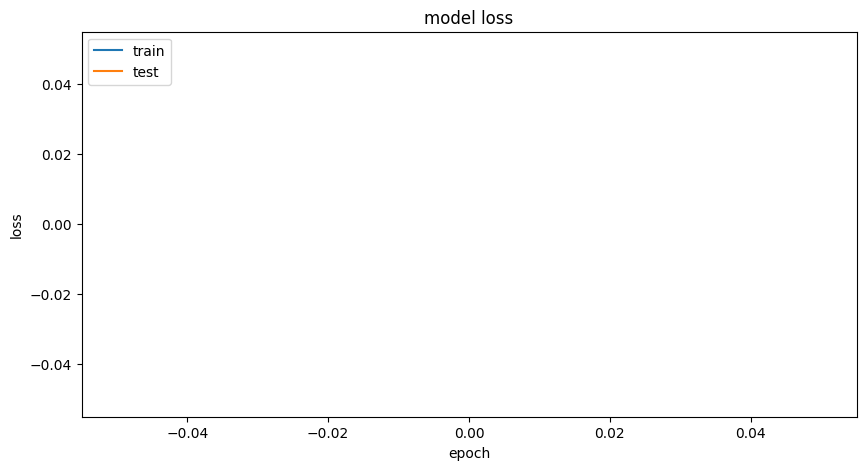

The loss for final model is  nan


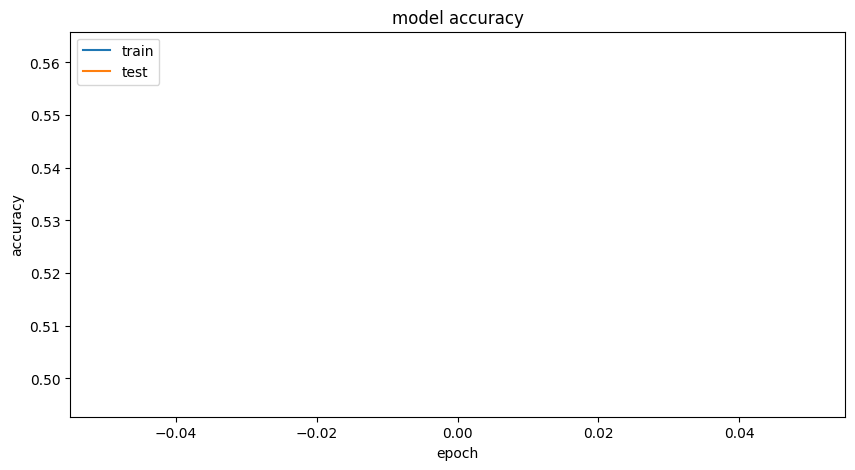

The accuracy for final model is  0.5625


In [48]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [49]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 1633 images belonging to 2 classes.


In [50]:
best_model = load_model('vgg16/vgg16_stage1_fc-0.565.hdf5')

In [51]:
y_pred = best_model.predict(x_test)

1633/1633 [==============================] - 166s 102ms/step


In [52]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.5211526670754139
Recall on test data for final baseline model 1.0
-------------------------------------------------- Confusion matrix --------------------------------------------------


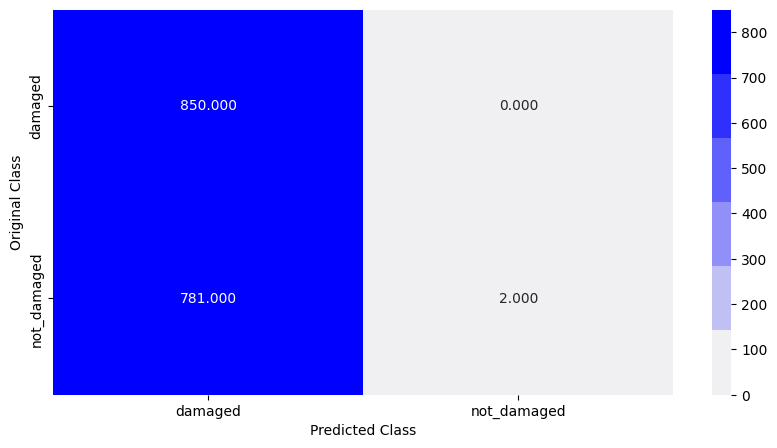

In [53]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [54]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage1 FC','Accuracy':'0.930','Precision':'0.919','Recall':'0.943'},ignore_index= True)

AttributeError: 'DataFrame' object has no attribute 'append'

### Stage 2

In [ ]:
model = create_model(3,'softmax')

In [ ]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

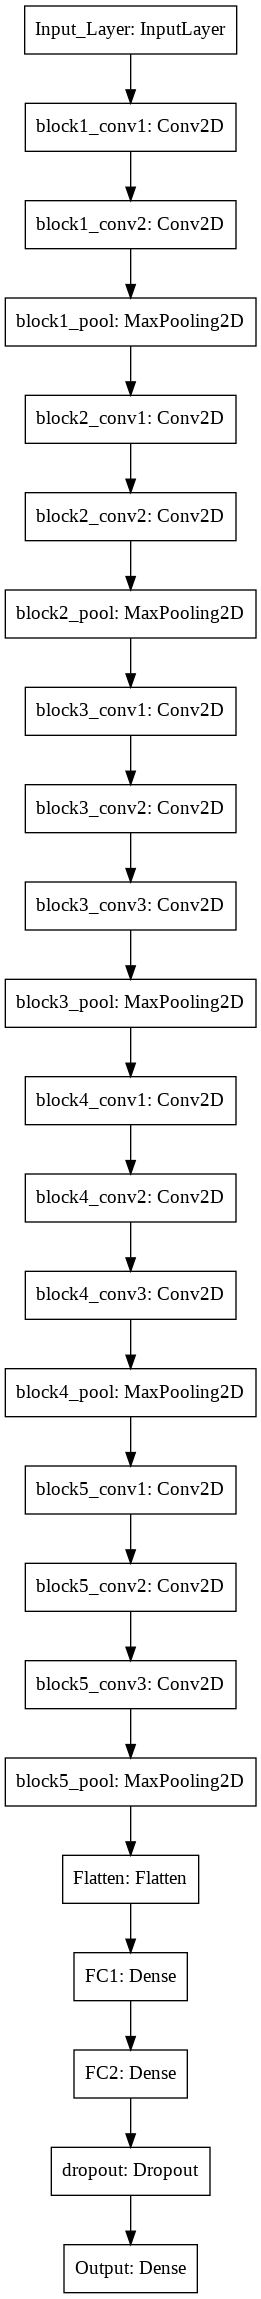

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage2_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [ ]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [ ]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [ ]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

Epoch 1/50
247/246 [==============================] - ETA: 0s - loss: 6.7872 - accuracy: 0.5025
Epoch 00001: val_accuracy improved from -inf to 0.55307, saving model to vgg16/vgg16_stage2_fc-0.553.hdf5
247/246 [==============================] - 16s 66ms/step - loss: 6.7872 - accuracy: 0.5025 - val_loss: 2.9728 - val_accuracy: 0.5531
Epoch 2/50
247/246 [==============================] - ETA: 0s - loss: 1.4506 - accuracy: 0.7594
Epoch 00002: val_accuracy improved from 0.55307 to 0.63128, saving model to vgg16/vgg16_stage2_fc-0.631.hdf5
247/246 [==============================] - 16s 64ms/step - loss: 1.4506 - accuracy: 0.7594 - val_loss: 1.9265 - val_accuracy: 0.6313
Epoch 3/50
247/246 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.8492
Epoch 00003: val_accuracy did not improve from 0.63128
247/246 [==============================] - 16s 63ms/step - loss: 0.5997 - accuracy: 0.8492 - val_loss: 1.9793 - val_accuracy: 0.6257
Epoch 4/50
247/246 [=======================

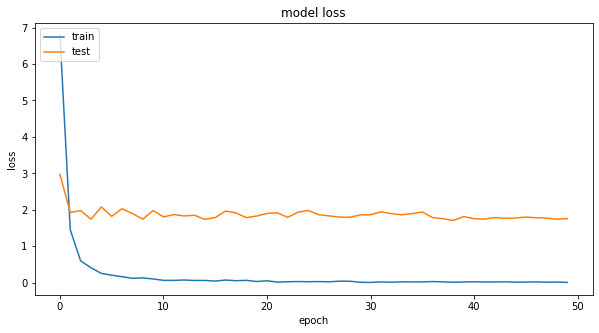

The loss for final model is  1.7818559408187866


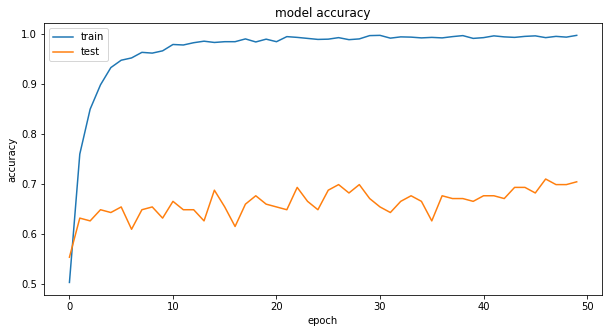

The accuracy for final model is  0.7094972133636475


In [ ]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [ ]:
best_model = load_model('vgg16/vgg16_stage2_fc-0.709.hdf5')

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is 0.7168209876543209
Average Recall is 0.7068407862278906
-------------------------------------------------- Confusion Matrix --------------------------------------------------


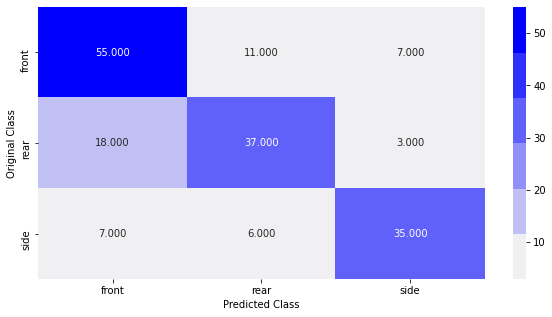

-------------------------------------------------- Precision Matrix --------------------------------------------------


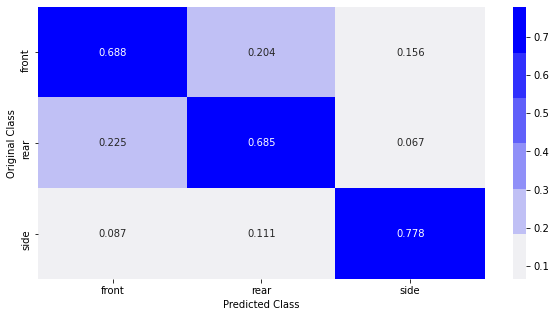

-------------------------------------------------- Recall Matrix --------------------------------------------------


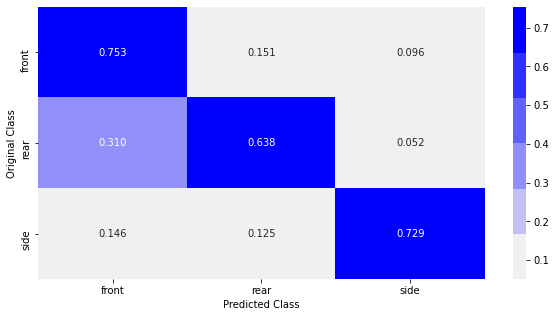

In [ ]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [ ]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage2 FC','Accuracy':'0.709','Precision':'0.717','Recall':'0.707'},ignore_index= True)

### Stage 3

In [ ]:
model = create_model(3,'softmax')

In [ ]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

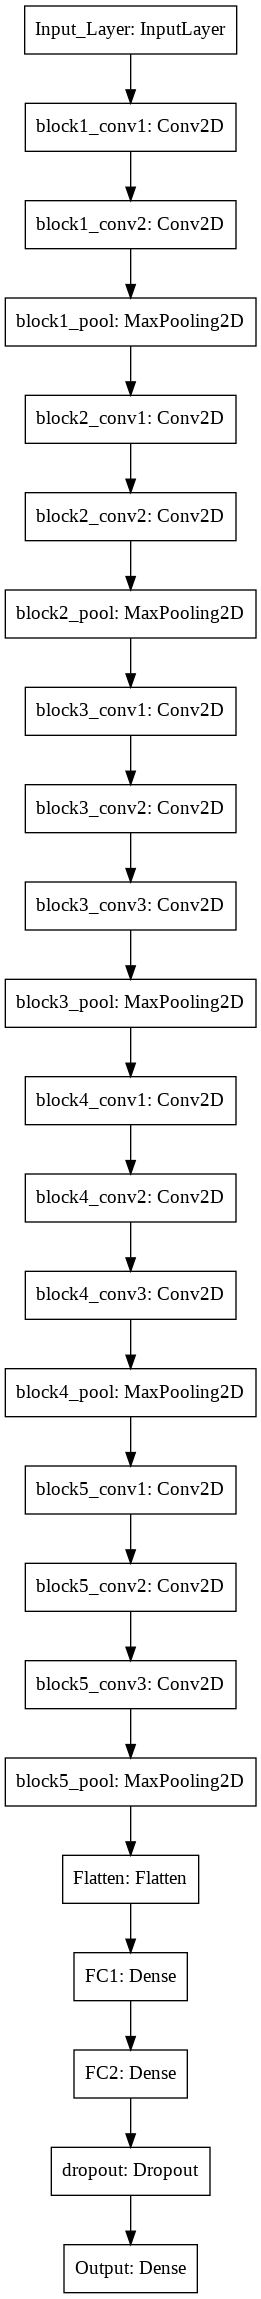

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage3_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [ ]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [ ]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [ ]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

Epoch 1/50
245/244 [==============================] - ETA: 0s - loss: 5.7159 - accuracy: 0.5174
Epoch 00001: val_accuracy improved from -inf to 0.58480, saving model to vgg16/vgg16_stage3_fc-0.585.hdf5
245/244 [==============================] - 16s 66ms/step - loss: 5.7159 - accuracy: 0.5174 - val_loss: 2.5951 - val_accuracy: 0.5848
Epoch 2/50
245/244 [==============================] - ETA: 0s - loss: 1.2080 - accuracy: 0.7686
Epoch 00002: val_accuracy improved from 0.58480 to 0.61404, saving model to vgg16/vgg16_stage3_fc-0.614.hdf5
245/244 [==============================] - 16s 64ms/step - loss: 1.2080 - accuracy: 0.7686 - val_loss: 2.5623 - val_accuracy: 0.6140
Epoch 3/50
245/244 [==============================] - ETA: 0s - loss: 0.5911 - accuracy: 0.8463
Epoch 00003: val_accuracy improved from 0.61404 to 0.61988, saving model to vgg16/vgg16_stage3_fc-0.620.hdf5
245/244 [==============================] - 16s 64ms/step - loss: 0.5911 - accuracy: 0.8463 - val_loss: 2.1390 - val_accura

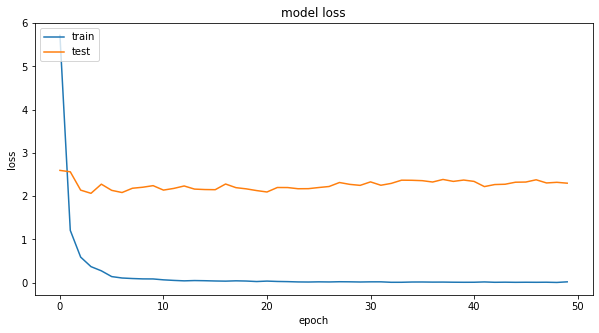

The loss for final model is  2.0651118755340576


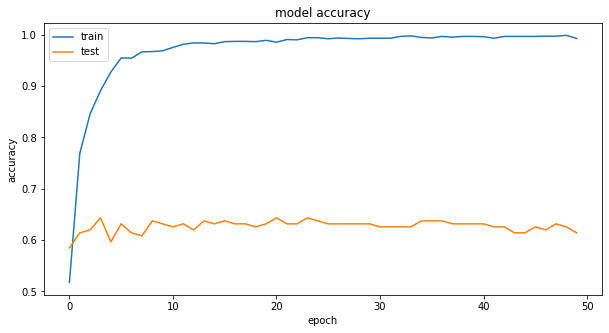

The accuracy for final model is  0.6432748436927795


In [ ]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [ ]:
best_model = load_model('vgg16/vgg16_stage3_fc-0.643.hdf5')

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is 0.6502555824589723
Average Recall is 0.6370172311348782
-------------------------------------------------- Confusion Matrix --------------------------------------------------


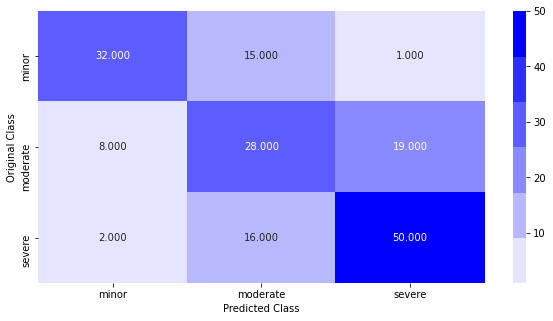

-------------------------------------------------- Precision Matrix --------------------------------------------------


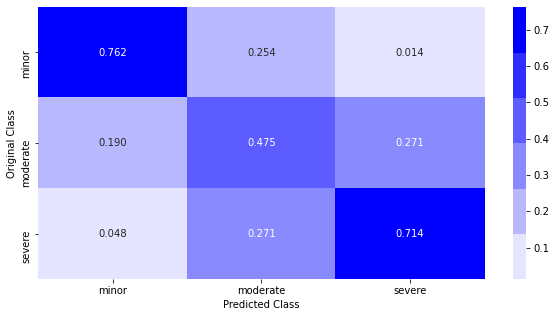

-------------------------------------------------- Recall Matrix --------------------------------------------------


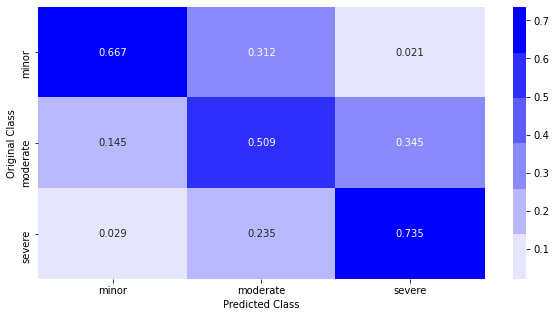

In [ ]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [ ]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage3 FC','Accuracy':'0.643','Precision':'0.650','Recall':'0.637'},ignore_index= True)

### CNN (Training All layers only)

In [ ]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    vgg16 = applications.VGG16(include_top = False,weights = 'imagenet',input_tensor = input_layer)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(vgg16.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [ ]:
model = create_model(1,'sigmoid')

In [ ]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

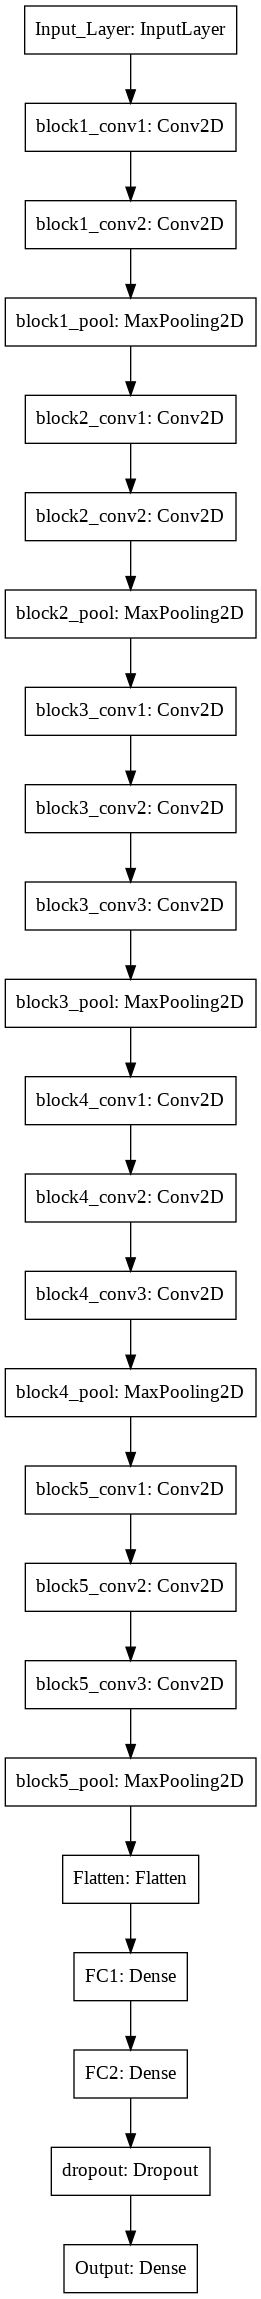

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage1_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [ ]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [ ]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3680 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [ ]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

Epoch 1/50
460/460 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.7918
Epoch 00001: val_accuracy improved from -inf to 0.90000, saving model to vgg16/vgg16_stage1_all-0.900.hdf5
460/460 [==============================] - 81s 175ms/step - loss: 0.7265 - accuracy: 0.7918 - val_loss: 0.2494 - val_accuracy: 0.9000
Epoch 2/50
460/460 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.8889
Epoch 00002: val_accuracy improved from 0.90000 to 0.91739, saving model to vgg16/vgg16_stage1_all-0.917.hdf5
460/460 [==============================] - 87s 188ms/step - loss: 0.2766 - accuracy: 0.8889 - val_loss: 0.2017 - val_accuracy: 0.9174
Epoch 3/50
460/460 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.9274
Epoch 00003: val_accuracy improved from 0.91739 to 0.92174, saving model to vgg16/vgg16_stage1_all-0.922.hdf5
460/460 [==============================] - 86s 188ms/step - loss: 0.1784 - accuracy: 0.9274 - val_loss: 0.1956 - val_

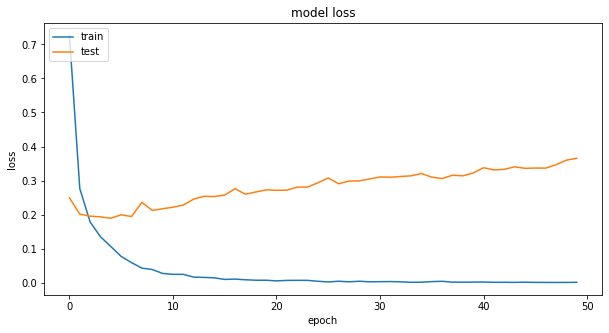

The loss for final model is  0.2809939980506897


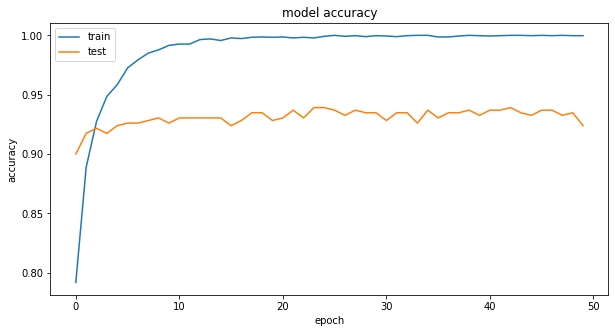

The accuracy for final model is  0.939130425453186


In [ ]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 460 images belonging to 2 classes.


In [ ]:
best_model = load_model('vgg16/vgg16_stage1_all-0.939.hdf5')

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 0.9353448275862069
Recall on test data for final baseline model 0.9434782608695652
-------------------------------------------------- Confusion matrix --------------------------------------------------


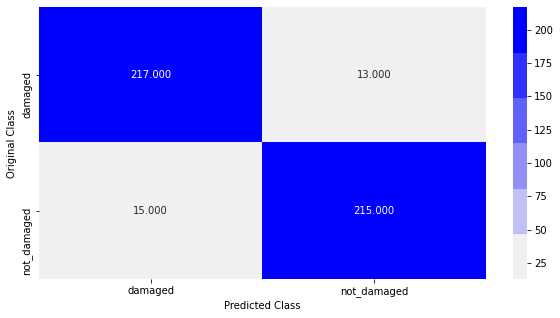

In [ ]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [ ]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage1 all','Accuracy':'0.939','Precision':'0.935','Recall':'0.943'},ignore_index= True)

### Stage 2

In [ ]:
model = create_model(3,'softmax')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

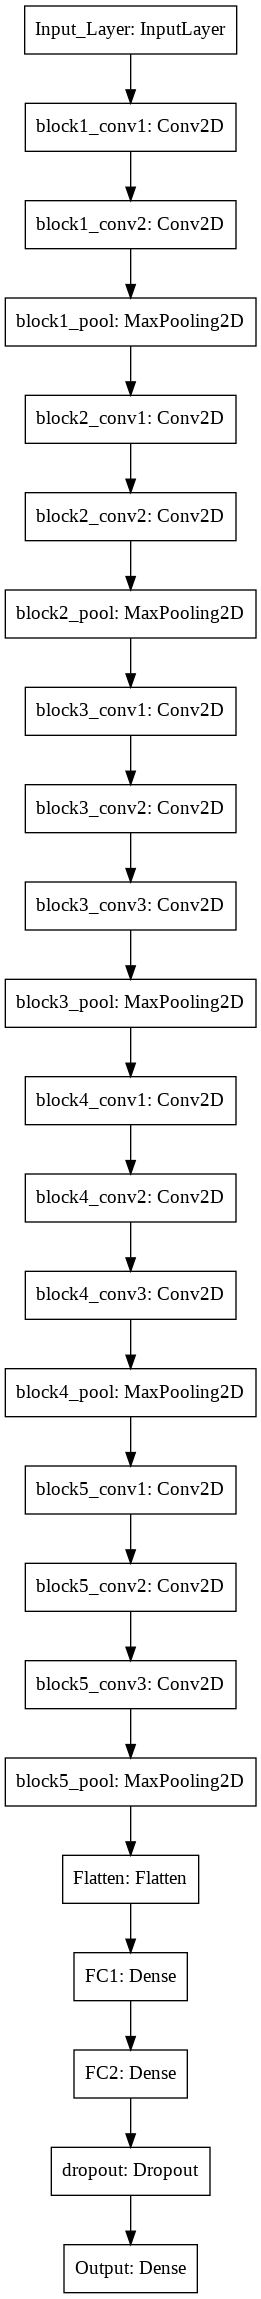

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage2_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [ ]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [ ]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 1970 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [ ]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

Epoch 1/50
247/246 [==============================] - ETA: 0s - loss: 1.8932 - accuracy: 0.3868
Epoch 00001: val_accuracy improved from -inf to 0.40782, saving model to vgg16/vgg16_stage2_all-0.408.hdf5
247/246 [==============================] - 42s 171ms/step - loss: 1.8932 - accuracy: 0.3868 - val_loss: 1.0950 - val_accuracy: 0.4078
Epoch 2/50
247/246 [==============================] - ETA: 0s - loss: 1.0682 - accuracy: 0.4391
Epoch 00002: val_accuracy improved from 0.40782 to 0.44134, saving model to vgg16/vgg16_stage2_all-0.441.hdf5
247/246 [==============================] - 42s 171ms/step - loss: 1.0682 - accuracy: 0.4391 - val_loss: 1.0751 - val_accuracy: 0.4413
Epoch 3/50
247/246 [==============================] - ETA: 0s - loss: 1.0355 - accuracy: 0.4756
Epoch 00003: val_accuracy improved from 0.44134 to 0.44693, saving model to vgg16/vgg16_stage2_all-0.447.hdf5
247/246 [==============================] - 43s 175ms/step - loss: 1.0355 - accuracy: 0.4756 - val_loss: 1.0777 - val_

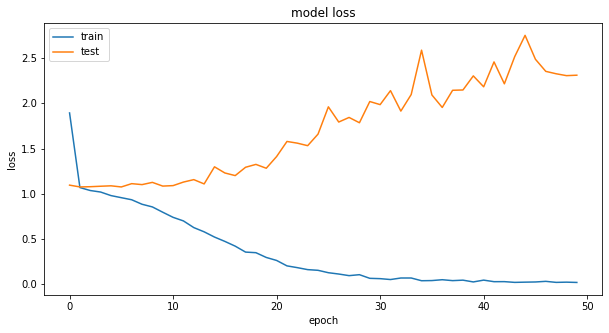

The loss for final model is  2.32627534866333


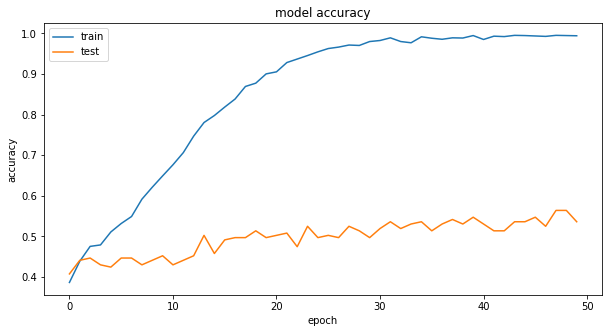

The accuracy for final model is  0.5642458200454712


In [ ]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [ ]:
best_model = load_model('vgg16/vgg16_stage2_all-0.564.hdf5')

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is 0.5587230672859861
Average Recall is 0.5584816039468851
-------------------------------------------------- Confusion Matrix --------------------------------------------------


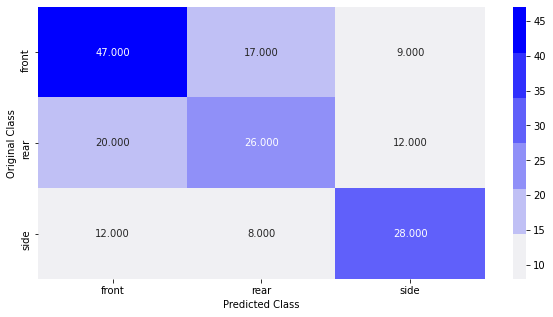

-------------------------------------------------- Precision Matrix --------------------------------------------------


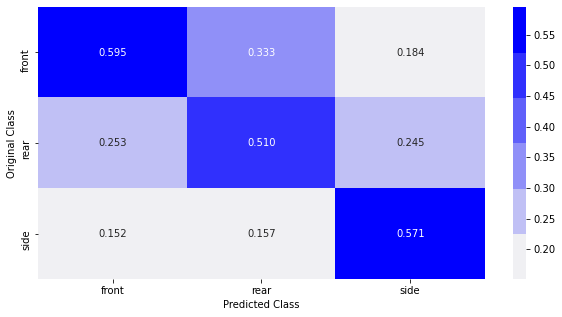

-------------------------------------------------- Recall Matrix --------------------------------------------------


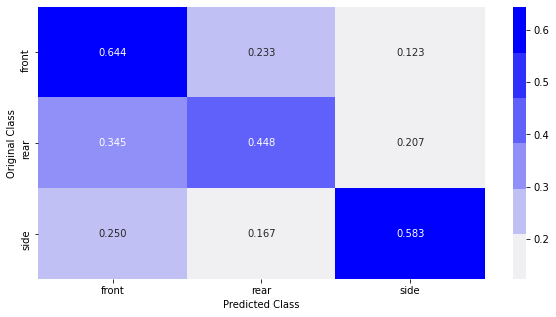

In [ ]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [ ]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage2 all','Accuracy':'0.564','Precision':'0.559','Recall':'0.558'},ignore_index= True)

### Stage 3

In [ ]:
model = create_model(3,'softmax')

In [ ]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

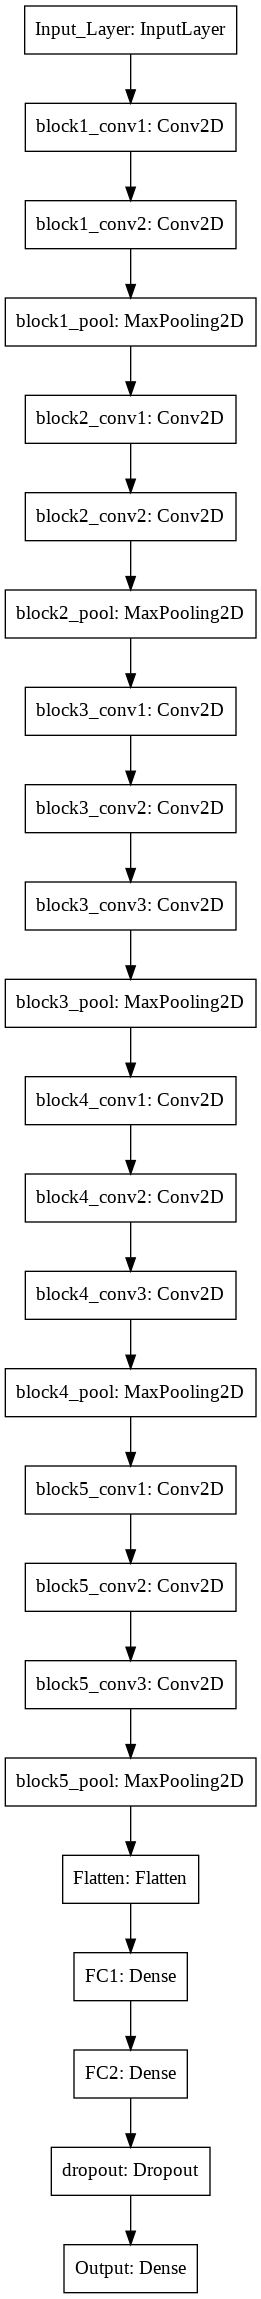

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
#Model saving based on validation accuracy score
filepath="vgg16/vgg16_stage3_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [ ]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [ ]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [ ]:
model.fit(train_generator   ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

Epoch 1/50
245/244 [==============================] - ETA: 0s - loss: 1.9932 - accuracy: 0.3534
Epoch 00001: val_accuracy improved from -inf to 0.42105, saving model to vgg16/vgg16_stage3_all-0.421.hdf5
245/244 [==============================] - 44s 180ms/step - loss: 1.9932 - accuracy: 0.3534 - val_loss: 1.0848 - val_accuracy: 0.4211
Epoch 2/50
245/244 [==============================] - ETA: 0s - loss: 1.0894 - accuracy: 0.3815
Epoch 00002: val_accuracy improved from 0.42105 to 0.43275, saving model to vgg16/vgg16_stage3_all-0.433.hdf5
245/244 [==============================] - 44s 178ms/step - loss: 1.0894 - accuracy: 0.3815 - val_loss: 1.0782 - val_accuracy: 0.4327
Epoch 3/50
245/244 [==============================] - ETA: 0s - loss: 1.0667 - accuracy: 0.4341
Epoch 00003: val_accuracy did not improve from 0.43275
245/244 [==============================] - 44s 179ms/step - loss: 1.0667 - accuracy: 0.4341 - val_loss: 1.0663 - val_accuracy: 0.4327
Epoch 4/50
245/244 [==================

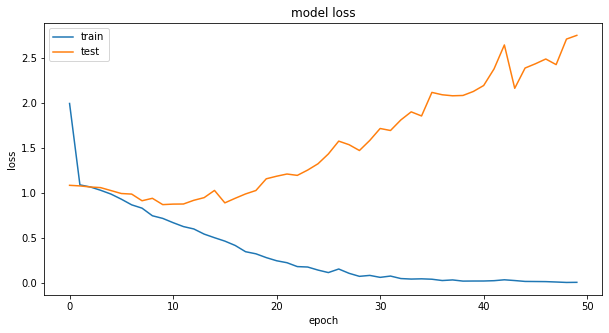

The loss for final model is  1.1951549053192139


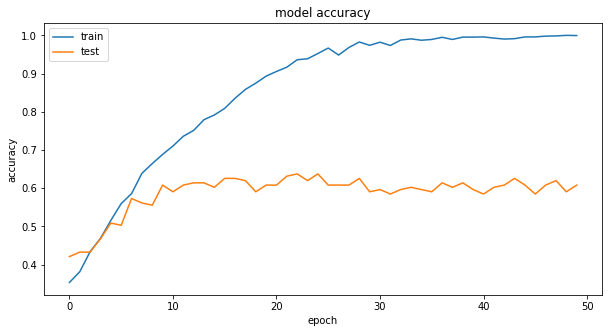

The accuracy for final model is  0.6374269127845764


In [ ]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [ ]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [ ]:
best_model = load_model('vgg16/vgg16_stage3_all-0.637.hdf5')

In [ ]:
y_pred = best_model.predict(x_test)

In [ ]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is 0.6321321321321322
Average Recall is 0.6210190136660724
-------------------------------------------------- Confusion Matrix --------------------------------------------------


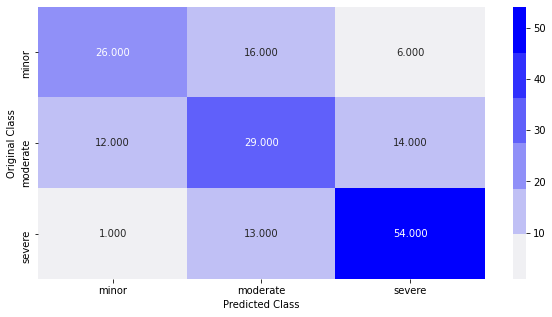

-------------------------------------------------- Precision Matrix --------------------------------------------------


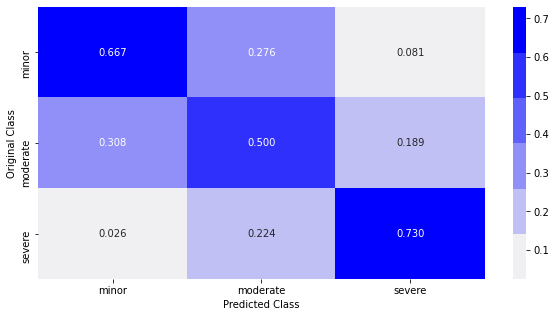

-------------------------------------------------- Recall Matrix --------------------------------------------------


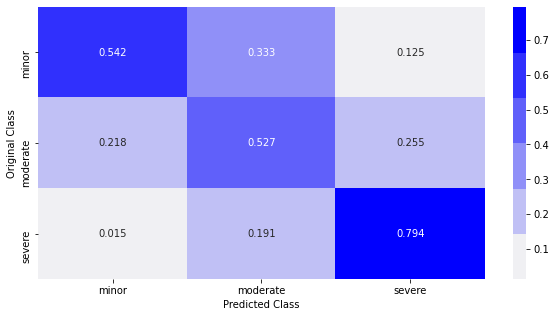

In [ ]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [ ]:
vgg16_scores = vgg16_scores.append({'Model':'Vgg16_stage3 all','Accuracy':'0.637','Precision':'0.632','Recall':'0.621'},ignore_index= True)

In [ ]:
vgg16_scores.to_csv('vgg16_scores.csv',index=False)